In [1]:
import os
os.chdir("..")
os.getcwd()

'/Users/laurasisson/odor-pair'

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import tqdm
import collections
import re
import json
import utils

In [3]:
random_seed = 3
random.seed(random_seed)

In [4]:
with open("dataset/full.json") as f:
    full_data = json.load(f)
full_data[0]

{'mol1': 'CCCCC/C=C/C(=O)OC',
 'mol1_notes': ['violet',
  'sweet',
  'oily',
  'melon',
  'pear',
  'hairy',
  'costus',
  'fruity',
  'violet leaf',
  'waxy',
  'fresh',
  'green'],
 'mol2': 'CCCCCOC(=O)CCC',
 'mol2_notes': ['cherry',
  'sweet',
  'pineapple',
  'fruity',
  'banana',
  'tropical'],
 'blend_notes': ['animal', 'fruity', 'waxy']}

In [5]:
import collections
blend_notes = collections.Counter()
mol_to_notes = dict()
for d in full_data:
    blend_notes.update(d["blend_notes"])
    mol_to_notes[d["mol1"]] = d["mol1_notes"]
    mol_to_notes[d["mol2"]] = d["mol2_notes"]
blend_notes.most_common(10)

[('fruity', 50409),
 ('floral', 47627),
 ('green', 29375),
 ('waxy', 11092),
 ('herbal', 9157),
 ('woody', 8707),
 ('balsamic', 7047),
 ('citrus', 5544),
 ('spicy', 5291),
 ('fatty', 4679)]

In [6]:
with open("charts/data/name_to_smiles.json") as f:
    name_to_smiles = json.load(f)
smiles_to_name = {v:k for k,v in name_to_smiles.items()}
next(iter(name_to_smiles.items())), next(iter(smiles_to_name.items()))

(('amyl butyrate', 'CCCCCOC(=O)CCC'), ('CCCCCOC(=O)CCC', 'amyl butyrate'))

In [7]:
import collections
mol_counts = collections.Counter()
for d in full_data:
    mol_counts[d["mol1"]] += 1
    mol_counts[d["mol2"]] += 1
mol_counts.most_common(10)

[('CC(CC1=CC2=C(C=C1)OCO2)C=O', 807),
 ('OC(C1OC(\\C=C)(CC1)C)(C)C', 806),
 ('CC(CCC=C(C)C)CCOC(=O)C', 784),
 ('CC(=CCCC(C)(C=C)O)C', 765),
 ('CCCCCOC(=O)C1=CC=CC=C1', 741),
 ('CCC(C)C(=O)OCCC1=CC=CC=C1', 734),
 ('CCCCCCCCCO', 727),
 ('CCCCCOC(=O)C1=CC=CC=C1O', 721),
 ('CC(=O)OCCC1=CC=CC=C1', 695),
 ('CCOC(=O)C=CC1=CC=CC=C1', 675)]

In [8]:
import graph.utils

edge_to_notes = {graph.utils.sort(d["mol1"],d["mol2"]):d["blend_notes"] for d in full_data}

In [9]:
def clean(name):
    # Remove parentheticals
    return re.sub(r"[\(\[].*?[\)\]]", "", name)
smiles_to_name = {s:clean(name) for s, name in smiles_to_name.items() if clean(name)}

In [10]:
sample_size = 15
backbone = {mol for mol, _ in mol_counts.most_common(sample_size)}
for mol in backbone:
    assert mol in smiles_to_name

In [11]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(list(backbone), test_size=0.5, random_state=random_seed)

train, test = list(train), list(test)
node_order = train + test

In [12]:
G = nx.Graph()
for d in full_data:
    m1,m2 = d["mol1"],d["mol2"]
    if not m1 in backbone or not m2 in backbone:
        continue
    m1, m2 = graph.utils.sort(m1,m2)
    G.add_edge(m1,m2)
len(G.edges())/len(G.nodes())

6.6

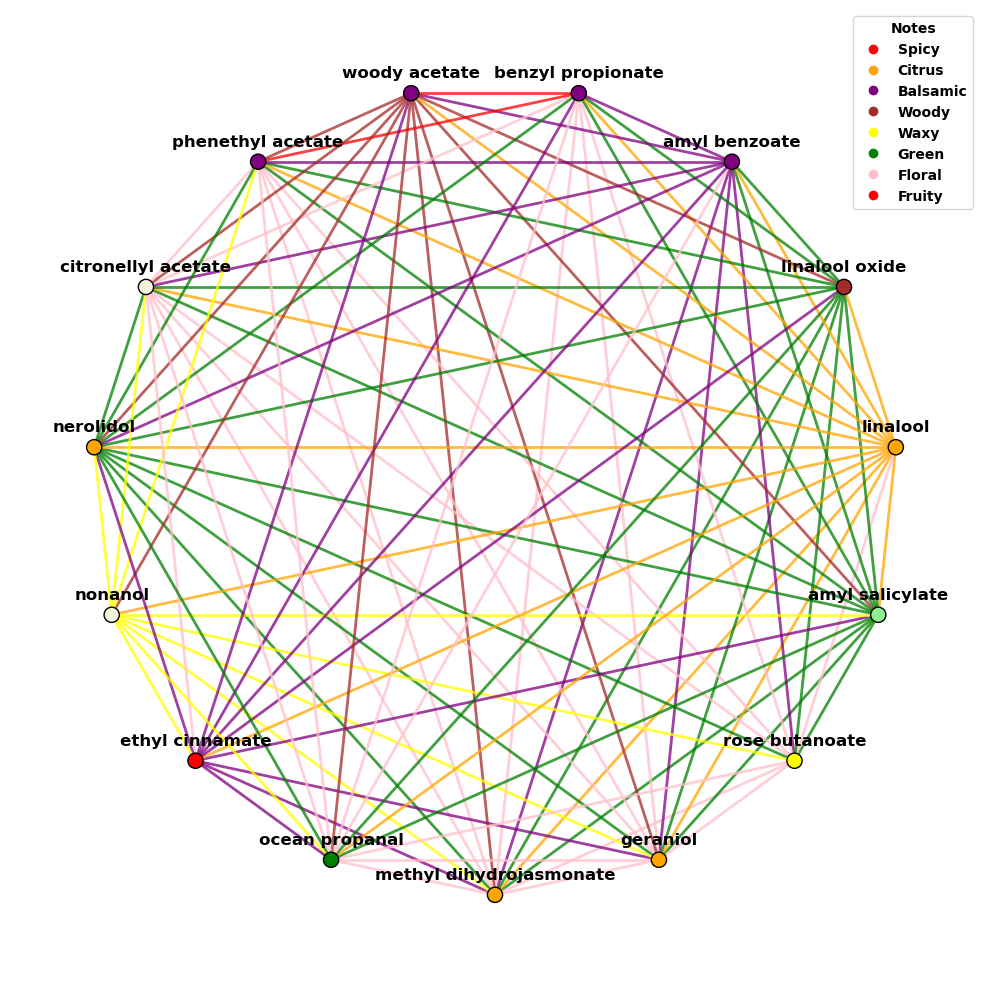

In [13]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import networkx as nx
import collections
import random
import re

# Suppress specific DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*alltrue.*")

node_size = 120
small_edge = 2
big_edge = 3

yoffset = 5e-2

used = set()

# Define your note to color mapping
note_color_mapping = {
    'fatty': 'beige',
    'spicy': 'red',
    'citrus': 'orange',
    'balsamic': 'purple',
    'woody': 'brown',
    'herbal': 'lightgreen',
    'waxy': 'yellow',
    'green': 'green',
    'floral': 'pink',
    'fruity': 'red'
}

def get_color_from_notes(notes):
    for note, color in note_color_mapping.items():
        if note in notes:
            return color
    return 'gray'  # default color if no matching note

def get_edge_style(edge):
    global used
    
    m1, m2 = edge
    notes = edge_to_notes[graph.utils.sort(m1,m2)]
    color = get_color_from_notes(notes)
    used.add(color)
    return 'solid', color, small_edge

def get_node_color(node):
    notes = mol_to_notes[node]
    return get_color_from_notes(notes)

fig, ax = utils.standard_fig_ax()

# Create a new graph and add nodes in the specified order
ordered_subgraph = nx.Graph()
ordered_subgraph.add_nodes_from(node_order)

# Add all edges from the original graph to the new ordered graph
ordered_subgraph.add_edges_from(G.edges())
# Use circular layout with the ordered subgraph
pos = nx.circular_layout(ordered_subgraph)

# Rotate positions by 90 degrees
theta = -np.pi / 2  # 90 degrees in radians
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

pos = {node: np.dot(rotation_matrix, pos[node]) for node in pos}

# nx.draw_networkx_nodes(ordered_subgraph, pos, node_size=node_size, nodelist=ordered_subgraph.nodes(),
#                        node_color='black')
node_colors = [get_node_color(n) for n in ordered_subgraph.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_size, nodelist=ordered_subgraph.nodes(),
                       node_color=node_colors, edgecolors='black', linewidths=1)


# Get the edge styles, colors, and weights for the subgraph
edge_styles, edge_colors, edge_weights = list(zip(*[get_edge_style(edge) for edge in ordered_subgraph.edges()]))
nx.draw_networkx_edges(ordered_subgraph, pos, style=edge_styles, edge_color=edge_colors, width=edge_weights, alpha=.75)

# Clean the names for labels
labels = {s:smiles_to_name[s] for s in pos}
labels_pos = {k: [x, y + yoffset] for k, (x, y) in pos.items()}
nx.draw_networkx_labels(ordered_subgraph, labels_pos, labels=labels)

# Add legend with colors used
for note, color in note_color_mapping.items():
    if color not in used:
        continue
    ax.plot([], [], label=note.capitalize(), color=color, linestyle='', marker='o')

# Add the legend to the plot
plt.legend(title="Notes", loc="best")

plt.box(False)
carving_width = collections.Counter(edge_styles)["solid"]

plt.tight_layout()
utils.save_figures(f"backbone{sample_size}", fig)
plt.show()


7 train molecules and 8 test molecules.
Average degree = 6 and carving width = 52


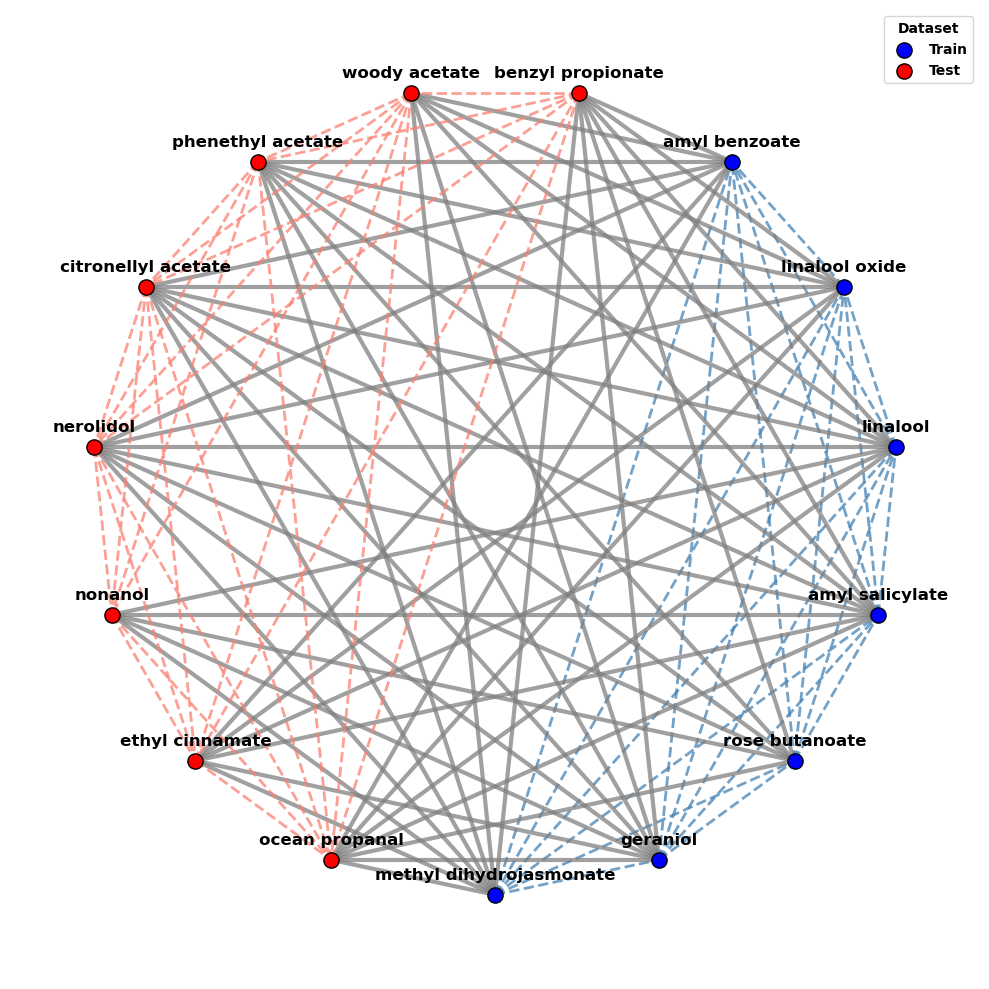

In [14]:
import warnings
import numpy as np

fig, ax = utils.standard_fig_ax()

train_color = "blue"
test_color = "red"

def get_edge_style(edge):
    m1,m2 = edge
    if m1 in train and m2 in train:
        return 'dashed', 'steelblue', small_edge
    if m1 in test and m2 in test:
        return 'dashed', 'salmon', small_edge
    return 'solid', 'grey', big_edge


# Create a new graph and add nodes in the specified order
ordered_subgraph = nx.Graph()
ordered_subgraph.add_nodes_from(node_order)

# Add all edges from the original graph to the new ordered graph
ordered_subgraph.add_edges_from(G.edges())
# Use circular layout with the ordered subgraph
pos = nx.circular_layout(ordered_subgraph)

# Rotate positions by 90 degrees
theta = -np.pi / 2  # 90 degrees in radians
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

pos = {node: np.dot(rotation_matrix, pos[node]) for node in pos}

nx.draw_networkx_nodes(G, pos, node_size=node_size, nodelist=train,
                       node_color=train_color, label='Train', edgecolors='black', linewidths=1)
nx.draw_networkx_nodes(G, pos, node_size=node_size, nodelist=test,
                       node_color=test_color, label='Test', edgecolors='black', linewidths=1)

edge_styles, edge_colors, edge_weights = list(zip(*[get_edge_style(edge) for edge in ordered_subgraph.edges()]))
nx.draw_networkx_edges(ordered_subgraph, pos,style=edge_styles,edge_color=edge_colors,width=edge_weights,alpha=.75)

labels = {k:clean(v) for k,v in smiles_to_name.items() if k in pos}
labels_pos = {k:[x,y+yoffset] for k,(x,y) in pos.items()}
nx.draw_networkx_labels(ordered_subgraph, labels_pos,labels=labels)

plt.legend(title="Dataset")

plt.box(False)
carving_width = collections.Counter(edge_styles)["solid"]


print(f"{len(train)} train molecules and {len(test)} test molecules.")
print(f"Average degree = {int(G.number_of_edges()/G.number_of_nodes())} and carving width = {carving_width}")

plt.tight_layout()
utils.save_figures(f"carving{sample_size}",fig)
plt.show()